In [1]:
import os
import json
import base64
import argparse
from datetime import datetime
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display, HTML
import io

In [2]:
from dotenv import load_dotenv
from huggingface_hub import login

# Load environment variables
load_dotenv()

# Login to Hugging Face if HF_TOKEN is available
if "HF_TOKEN" in os.environ:
    login(token=os.environ["HF_TOKEN"])

# Check if CUDA is available
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

f:\Thesis\DKH-Thesis\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Using device: cpu


In [3]:
# Import necessary modules from your codebase
from src.modules import EntitiesModule, ImageEvidencesModule, TextEvidencesModule
from src.mdatasets.newsclipping_datasets import MergedBalancedNewsClippingDataset

# Paths configuration (you can modify these as needed)
DATA_PATH = "F:/Thesis/DKH-Thesis/test_dataset"
ENTITIES_PATH = "F:/Thesis/DKH-Thesis/test_dataset/links_test.json"
IMAGE_EVIDENCES_PATH = "F:/Thesis/DKH-Thesis/queries_dataset/merged_balanced/inverse_search/test/test.json"
TEXT_EVIDENCES_PATH = "F:/Thesis/DKH-Thesis/queries_dataset/merged_balanced/direct_search/test/test.json"
OUTPUT_DIR = "./extracted_images"

# Create output directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "original"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "references"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "visualizations"), exist_ok=True)

# Initialize modules
entities_module = EntitiesModule(ENTITIES_PATH)
image_evidences_module = ImageEvidencesModule(IMAGE_EVIDENCES_PATH)
text_evidences_module = TextEvidencesModule(TEXT_EVIDENCES_PATH)

# Load dataset
dataset = MergedBalancedNewsClippingDataset(DATA_PATH)
print(f"Dataset loaded with {len(dataset)} items")

Dataset loaded with 7264 items


In [4]:
def save_image(base64_str, output_path):
    """Save a base64 encoded image to a file."""
    if not base64_str:
        return False
    
    try:
        # Make sure the directory exists
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # If the base64 string contains a header (e.g., "data:image/jpeg;base64,"), remove it
        if "," in base64_str:
            base64_str = base64_str.split(",", 1)[1]
            
        # Decode and save the image
        with open(output_path, "wb") as f:
            f.write(base64.b64decode(base64_str))
        return True
    except Exception as e:
        print(f"Error saving image to {output_path}: {e}")
        return False

def get_image_html(img_path, max_height=250):
    """Generate HTML to display an image with the given path."""
    if not os.path.exists(img_path):
        return f"<p>Image not found: {img_path}</p>"
    
    try:
        with open(img_path, "rb") as f:
            img_data = f.read()
        img_b64 = base64.b64encode(img_data).decode("utf-8")
        return f'<img src="data:image/jpeg;base64,{img_b64}" style="max-height:{max_height}px">'
    except Exception as e:
        return f"<p>Error loading image {img_path}: {str(e)}</p>"

def display_image_comparison(original_path, reference_paths, metadata=None):
    """Display the original image alongside its reference images in the notebook."""
    if not os.path.exists(original_path):
        print(f"Original image not found: {original_path}")
        return
    
    # Filter existing reference paths
    valid_ref_paths = [p for p in reference_paths if os.path.exists(p)]
    
    if not valid_ref_paths:
        print(f"No valid reference images found for {original_path}")
        return
    
    # Start building HTML
    html = "<div style='width:100%; overflow-x:auto;'>"
    
    # Add metadata if available
    if metadata:
        caption = metadata.get('caption', 'No caption available')
        label = metadata.get('label', None)
        
        html += f"<h3 style='color:red'>{caption}</h3>"
        if label is not None:
            label_text = "Out-of-Context" if label else "In-Context"
            label_color = "red" if label else "green"
            html += f"<p><strong style='color:{label_color}'>Ground Truth: {label_text}</strong></p>"
    
    # Add original image
    html += "<div style='margin-bottom:20px;'>"
    html += "<h4>Original Image</h4>"
    html += get_image_html(original_path, max_height=300)
    html += "</div>"
    
    # Add reference images
    html += "<h4>Reference Images</h4>"
    html += "<div style='display:flex; flex-wrap:nowrap; overflow-x:auto;'>"
    
    for i, ref_path in enumerate(valid_ref_paths):
        html += f"<div style='margin-right:10px; min-width:250px;'>"
        html += f"<p>Reference {i+1}</p>"
        html += get_image_html(ref_path, max_height=200)
        html += "</div>"
    
    html += "</div></div>"
    
    display(HTML(html))

def create_image_grid(original_path, reference_paths, output_path, metadata=None, max_refs=6):
    """Create a grid visualization with the original image and its references."""
    if not os.path.exists(original_path):
        print(f"Original image not found: {original_path}")
        return False
    
    # Filter existing reference paths
    valid_ref_paths = [p for p in reference_paths if os.path.exists(p)]
    
    if not valid_ref_paths:
        print(f"No valid reference images found for {original_path}")
        return False
    
    # Limit the number of reference images to show
    if len(valid_ref_paths) > max_refs:
        valid_ref_paths = valid_ref_paths[:max_refs]
    
    # Calculate grid dimensions
    n_refs = len(valid_ref_paths)
    fig = plt.figure(figsize=(16, 10))
    
    # Create a grid layout with original image taking up more space
    gs = GridSpec(2, 3, figure=fig)
    
    # Original image takes the top half
    ax_orig = fig.add_subplot(gs[0, :])
    ax_orig.imshow(np.array(Image.open(original_path)))
    ax_orig.set_title(f"metadata.get('caption', '')", fontsize=14)
    ax_orig.axis('off')
    
    # Add the caption if available
    # if metadata and 'caption' in metadata:
    #     caption = metadata.get('caption', '')
    #     fig.text(0.5, 0.95, f"Caption: {caption}", ha='center', fontsize=12, wrap=True, color='red')
    
    # Add the ground truth label if available
    if metadata and 'label' in metadata:
        label = metadata.get('label', '')
        label_text = f"Ground Truth: {'OOC' if label else 'NOOC'}"
        fig.text(0.5, 0.92, label_text, ha='center', fontsize=12, weight='bold', 
                color='red' if label else 'green')
    
    # Reference images in the bottom half
    for i, ref_path in enumerate(valid_ref_paths):
        if i >= 3:  # Maximum of 6 references (2 rows of 3)
            break
            
        ax = fig.add_subplot(gs[1, i])
        ax.imshow(np.array(Image.open(ref_path)))
        ax.set_title(f"Reference {i+1}", fontsize=12)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', dpi=150)
    plt.close(fig)
    return True

In [5]:
def extract_images_for_index(idx, min_references=10):
    """Extract the original image and reference images for a specific index."""
    try:
        print(f"Processing item {idx}")
        item = dataset[idx]
        
        # Get the original image
        original_image_base64 = item.get("image_base64")
        original_saved = False
        original_path = os.path.join(OUTPUT_DIR, "original", f"image_{idx}.jpg")
        
        if original_image_base64:
            original_saved = save_image(original_image_base64, original_path)
            if original_saved:
                print(f"Saved original image for item {idx}")
        
        # Get reference images from text evidences
        text_evidences = text_evidences_module.get_evidence_by_index(idx, query = item["caption"], threshold=0.85, reference_image=item["image_base64"], image_similarity_threshold=0.9, min_results=0)
        
        # Extract and save reference images
        ref_count = 0
        ref_saved_paths = []
        
        for i, evidence in enumerate(text_evidences):
            if evidence.image_data:
                ref_path = os.path.join(
                    OUTPUT_DIR, 
                    "references", 
                    f"image_{idx}_ref_{i}.jpg"
                )
                if save_image(evidence.image_data, ref_path):
                    ref_count += 1
                    ref_saved_paths.append(ref_path)
                    print(f"Saved reference image {i} for item {idx}")
        
        # Record the extraction results
        metadata = {
            "index": idx,
            "caption": item["caption"],
            "original_image": original_path if original_saved else None,
            "reference_images": ref_saved_paths,
            "reference_count": ref_count,
            "label": item.get("label")
        }
        
        # Save metadata
        metadata_path = os.path.join(OUTPUT_DIR, f"metadata_{idx}.json")
        with open(metadata_path, "w", encoding="utf-8") as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)
        
        # Create visualization
        if original_saved and ref_count > 0:
            viz_path = os.path.join(OUTPUT_DIR, "visualizations", f"comparison_{idx}.jpg")
            create_image_grid(original_path, ref_saved_paths, viz_path, metadata)
            
            # Display in notebook
            display_image_comparison(original_path, ref_saved_paths, metadata)
            
            return metadata, True
        else:
            reason = "No original image" if not original_saved else "No reference images"
            print(f"Extraction incomplete: {reason}")
            return metadata, False
            
    except Exception as e:
        print(f"Error processing item {idx}: {e}")
        return {"index": idx, "error": str(e)}, False

In [6]:
def batch_extract_images(indices, min_references=5):
    """Extract images for multiple indices."""
    successful_extractions = []
    failed_extractions = []
    
    for idx in indices:
        metadata, success = extract_images_for_index(idx, min_references)
        if success:
            successful_extractions.append(metadata)
        else:
            failed_extractions.append(metadata)
    
    # Save extraction summary
    summary = {
        "timestamp": datetime.now().isoformat(),
        "total_processed": len(indices),
        "successful_extractions": len(successful_extractions),
        "failed_extractions": len(failed_extractions),
    }
    
    summary_path = os.path.join(OUTPUT_DIR, "extraction_summary.json")
    with open(summary_path, "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)
    
    print(f"\nExtraction complete: {len(successful_extractions)} successful, {len(failed_extractions)} failed")
    return successful_extractions, failed_extractions

Processing random indices: [406, 410, 412, 486, 518, 544, 656, 672, 719, 746, 766, 792]
Processing item 406
Saved original image for item 406
Extraction incomplete: No reference images
Processing item 410
Saved original image for item 410
Saved reference image 0 for item 410
Saved reference image 1 for item 410
Saved reference image 2 for item 410
Saved reference image 3 for item 410



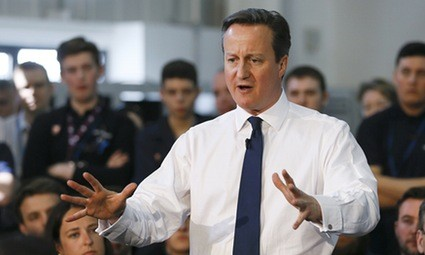
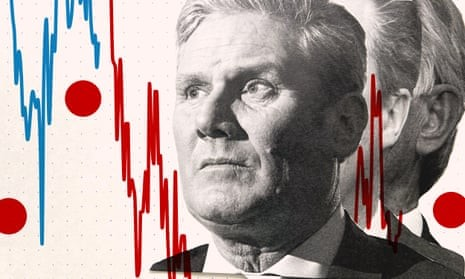
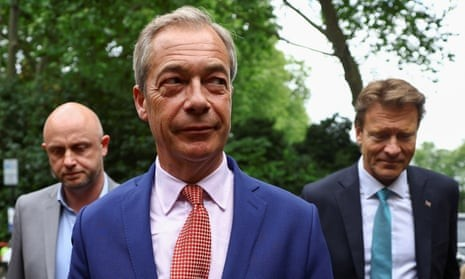
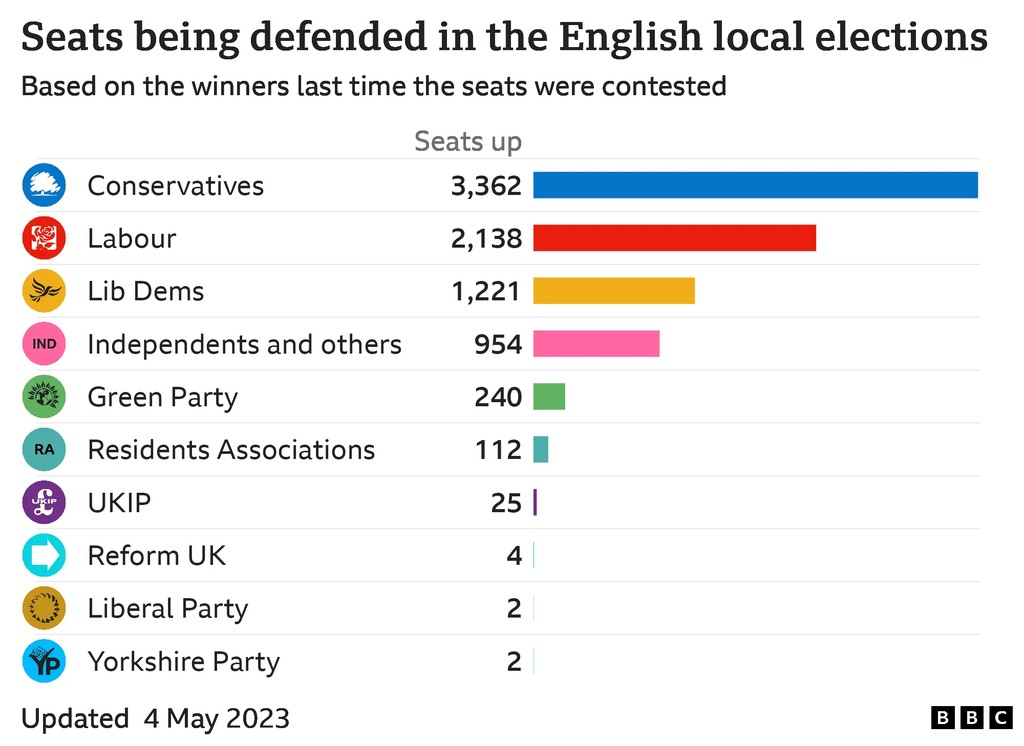
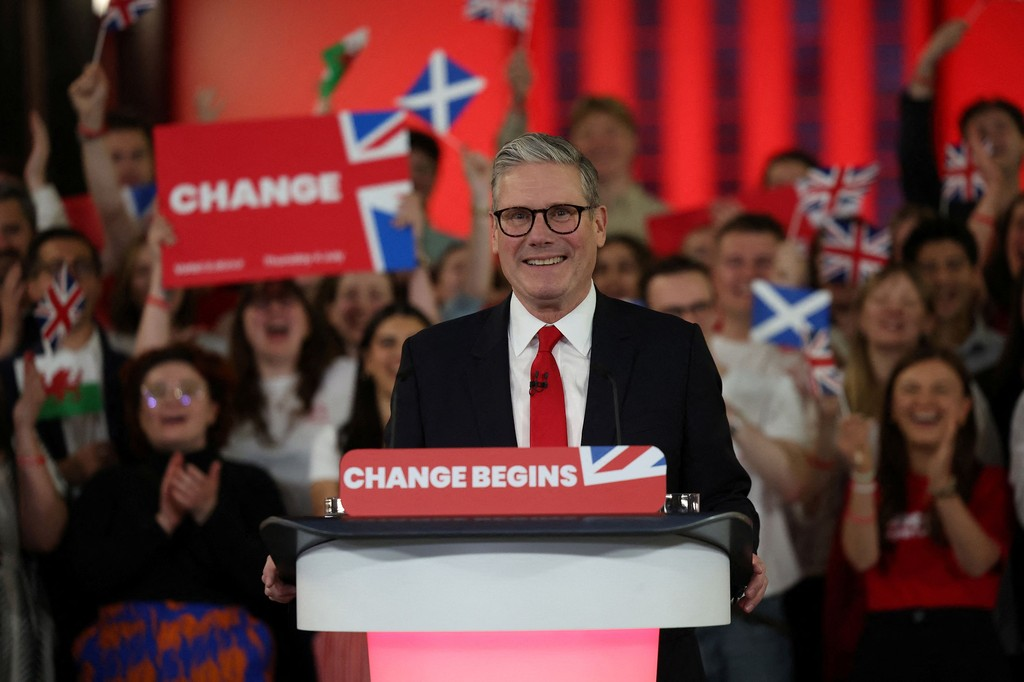

Processing item 412
Saved original image for item 412
Extraction incomplete: No reference images
Processing item 486
Saved original image for item 486
Error loading image queries_dataset\merged_balanced\direct_search\test\486\0.jpg: cannot write mode P as JPEG
Saved reference image 0 for item 486



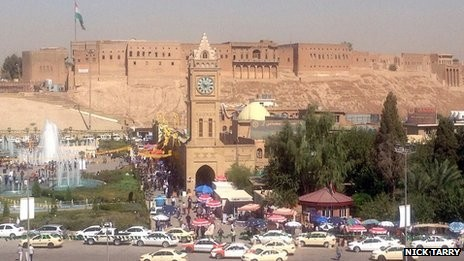
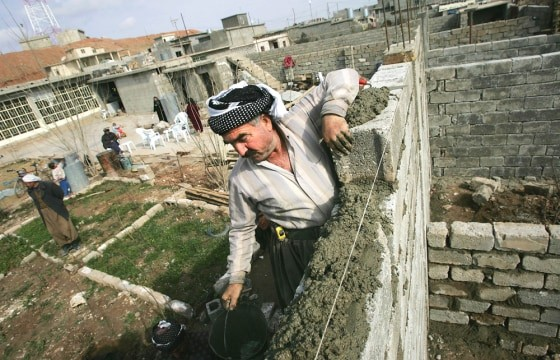

Processing item 518
Saved original image for item 518
Saved reference image 0 for item 518
Saved reference image 1 for item 518



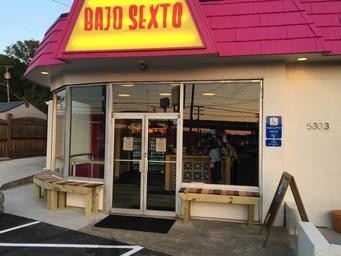
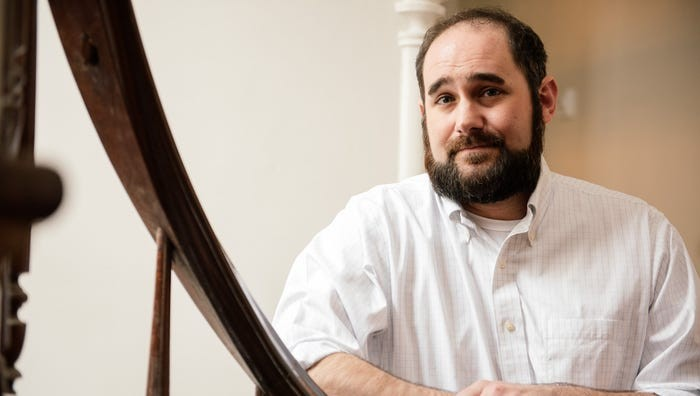
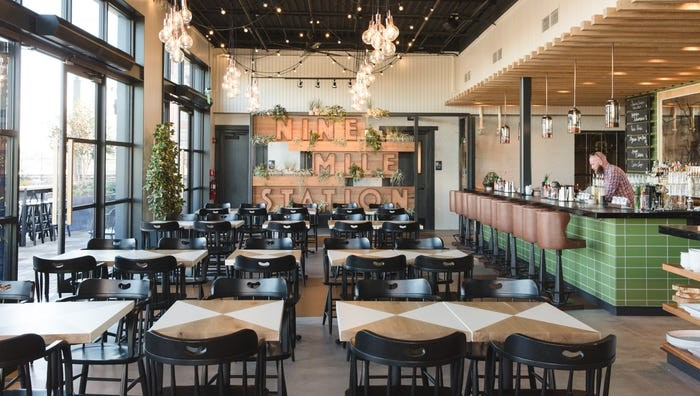

Processing item 544
Saved original image for item 544
Saved reference image 0 for item 544
Saved reference image 1 for item 544
Saved reference image 2 for item 544



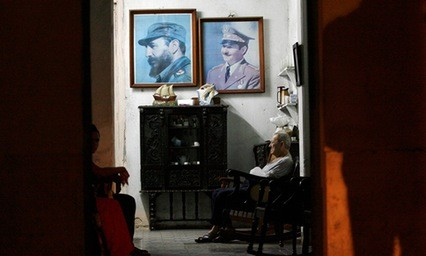
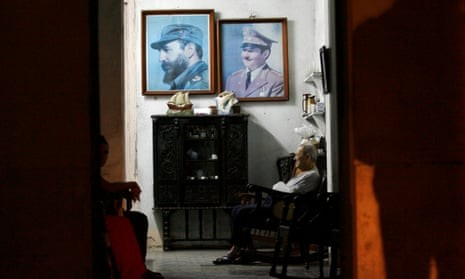
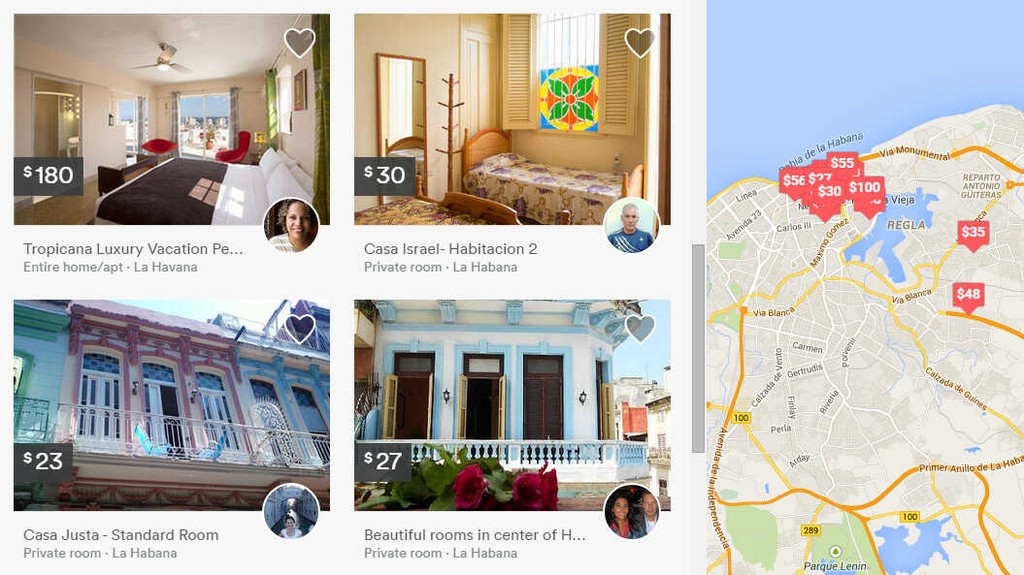
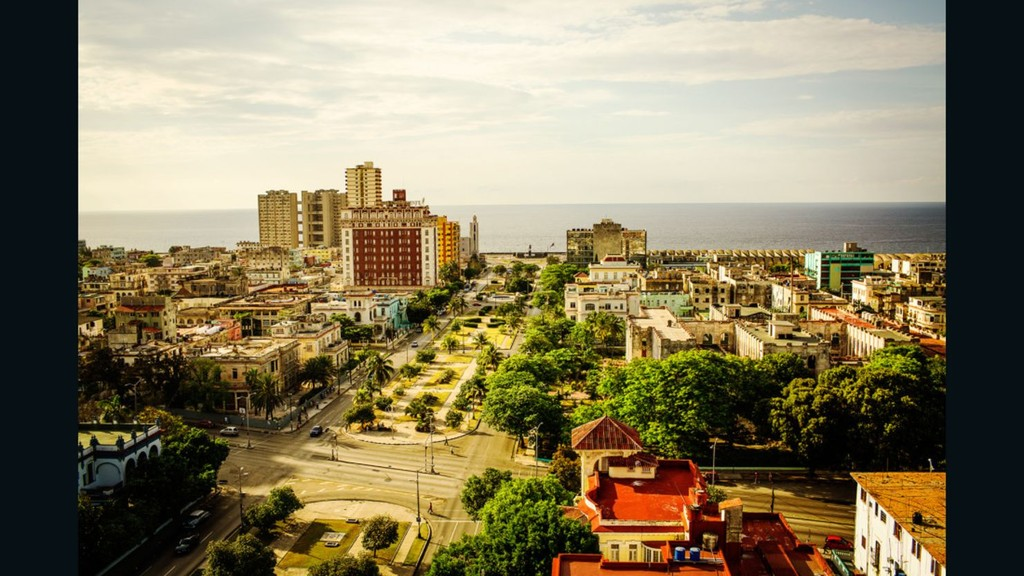

Processing item 656
Saved original image for item 656
Extraction incomplete: No reference images
Processing item 672
Saved original image for item 672
Extraction incomplete: No reference images
Processing item 719
Saved original image for item 719
Saved reference image 0 for item 719
Saved reference image 1 for item 719
Saved reference image 2 for item 719
Saved reference image 3 for item 719



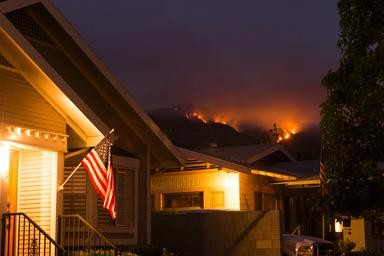
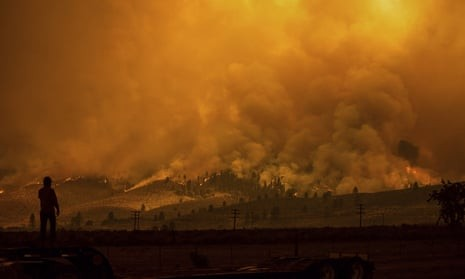
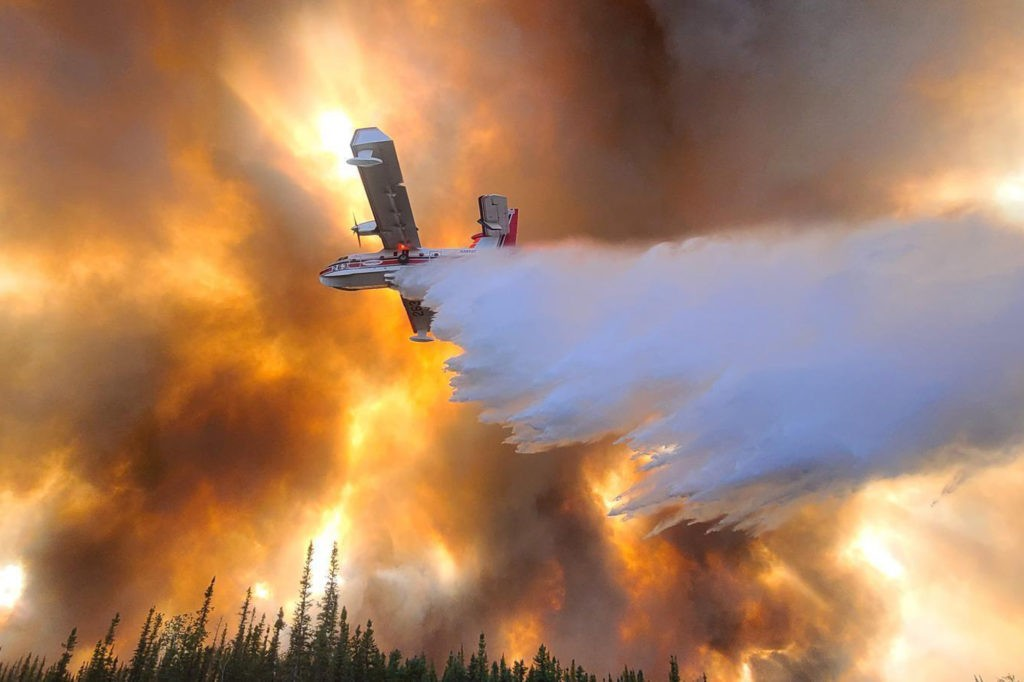
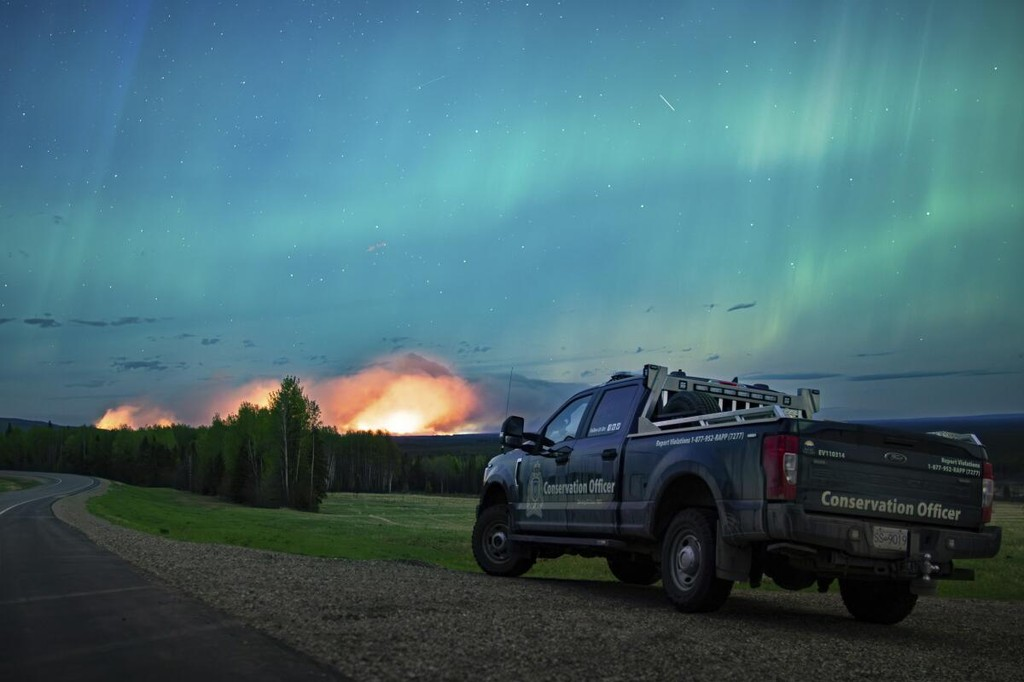
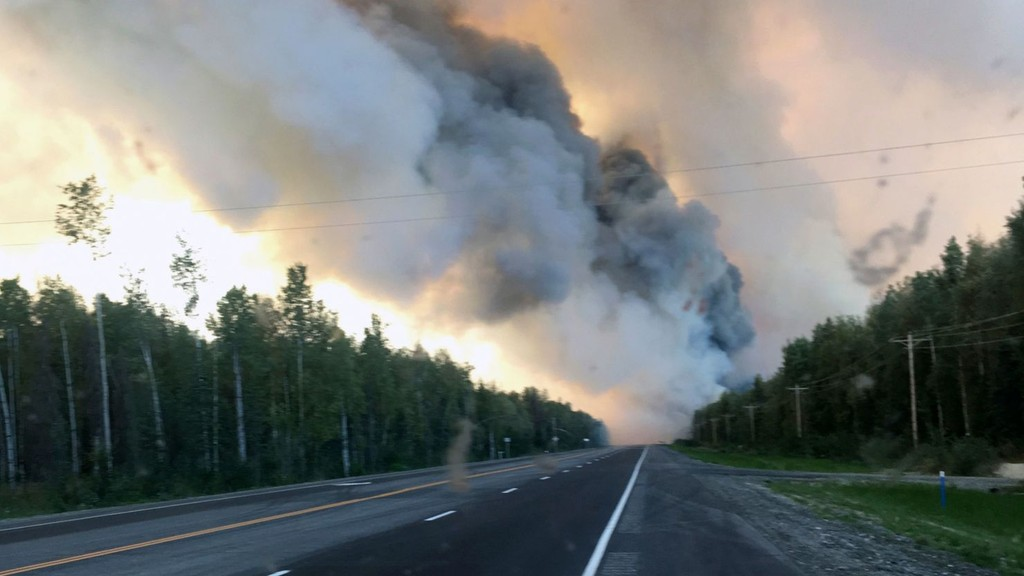

Processing item 746
Saved original image for item 746
Saved reference image 0 for item 746
Saved reference image 1 for item 746
Saved reference image 2 for item 746



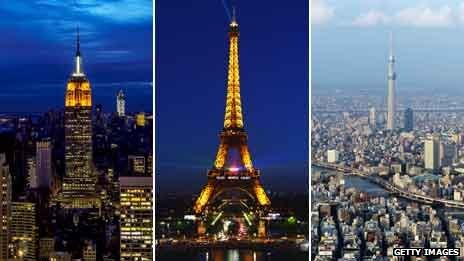
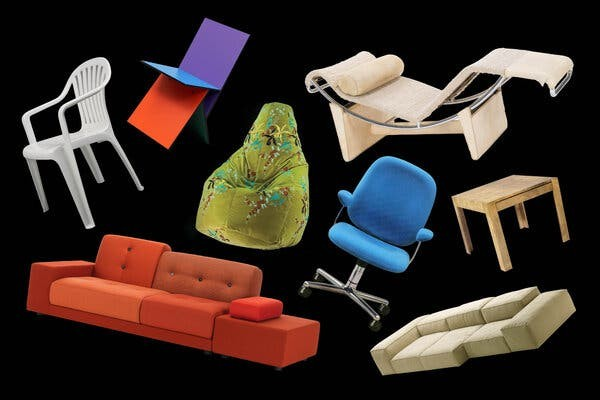
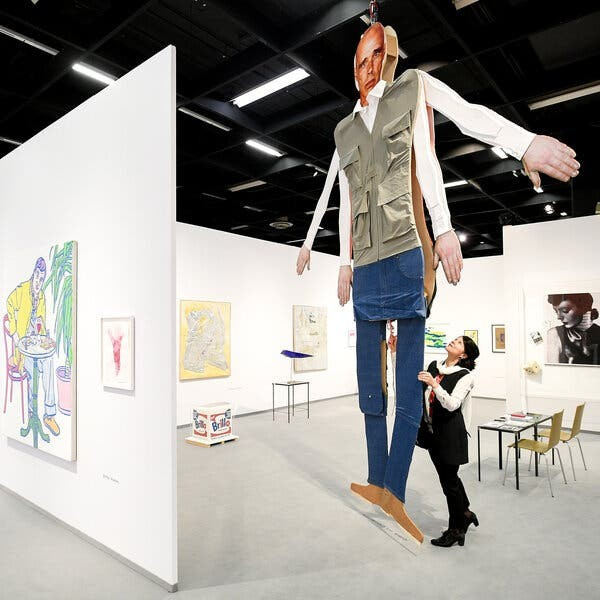
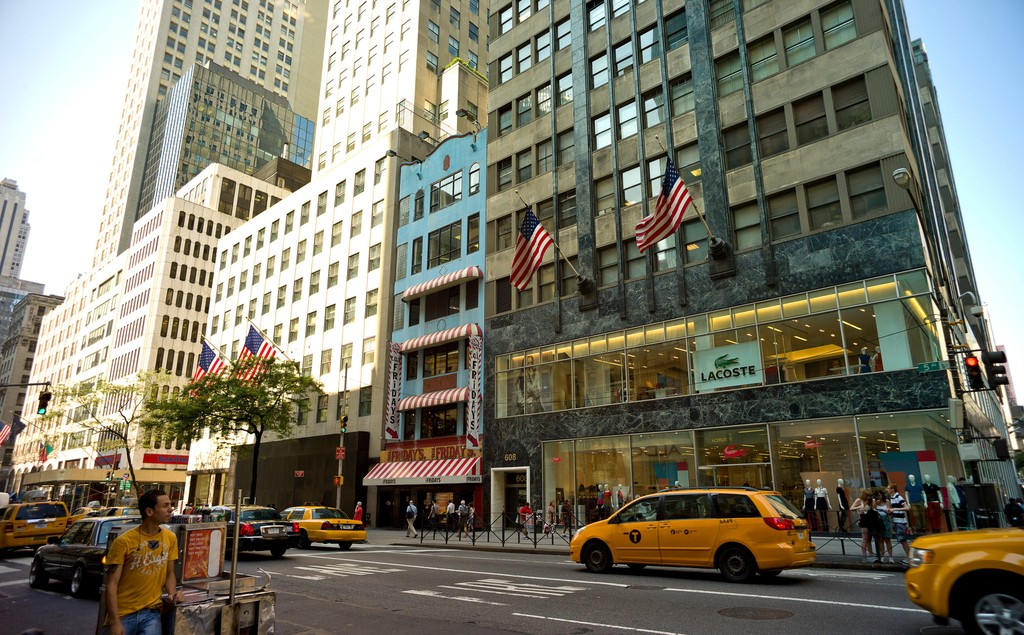

Processing item 766
Saved original image for item 766
Extraction incomplete: No reference images
Processing item 792
Saved original image for item 792
Extraction incomplete: No reference images

Extraction complete: 6 successful, 6 failed


In [7]:
# Load random indices from a file
random_indices_file = "src/incorrect_index.txt"  # Change to your file path

if os.path.exists(random_indices_file):
    with open(random_indices_file, "r") as f:
        random_indices = [int(line.strip()) for line in f.readlines()]
    
    # Process the first 10 random indices
    sample_indices = random_indices[10:]
    print(f"Processing random indices: {sample_indices}")
    successful, failed = batch_extract_images(sample_indices)
else:
    print(f"Random indices file not found: {random_indices_file}")